In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

In [2]:
df = pd.read_csv('insurance3r2.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   steps           1338 non-null   int64  
 4   children        1338 non-null   int64  
 5   smoker          1338 non-null   int64  
 6   region          1338 non-null   int64  
 7   charges         1338 non-null   float64
 8   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 94.2 KB


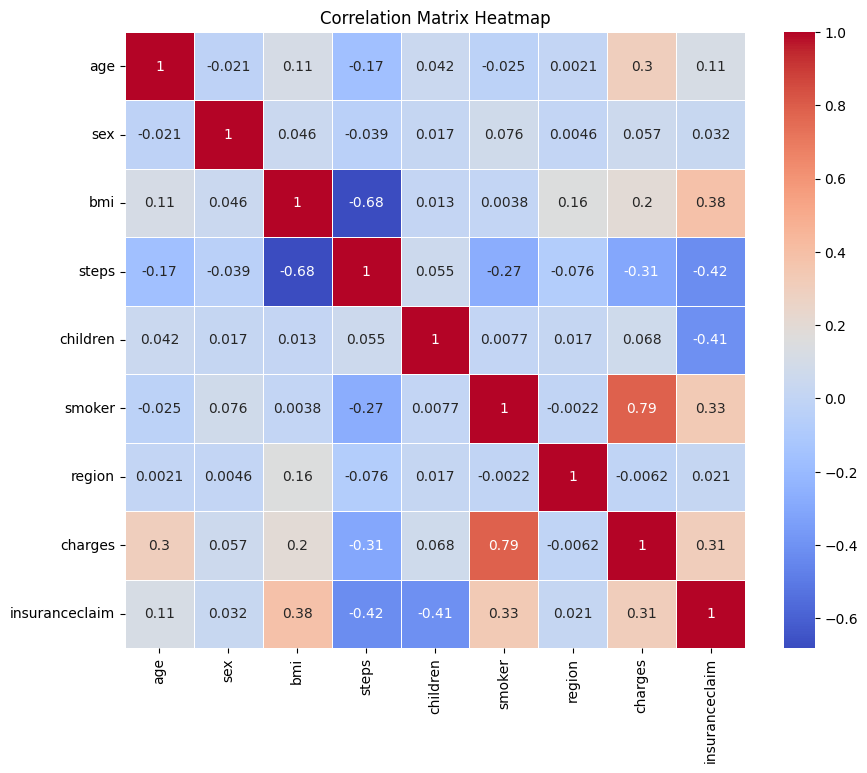

In [4]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

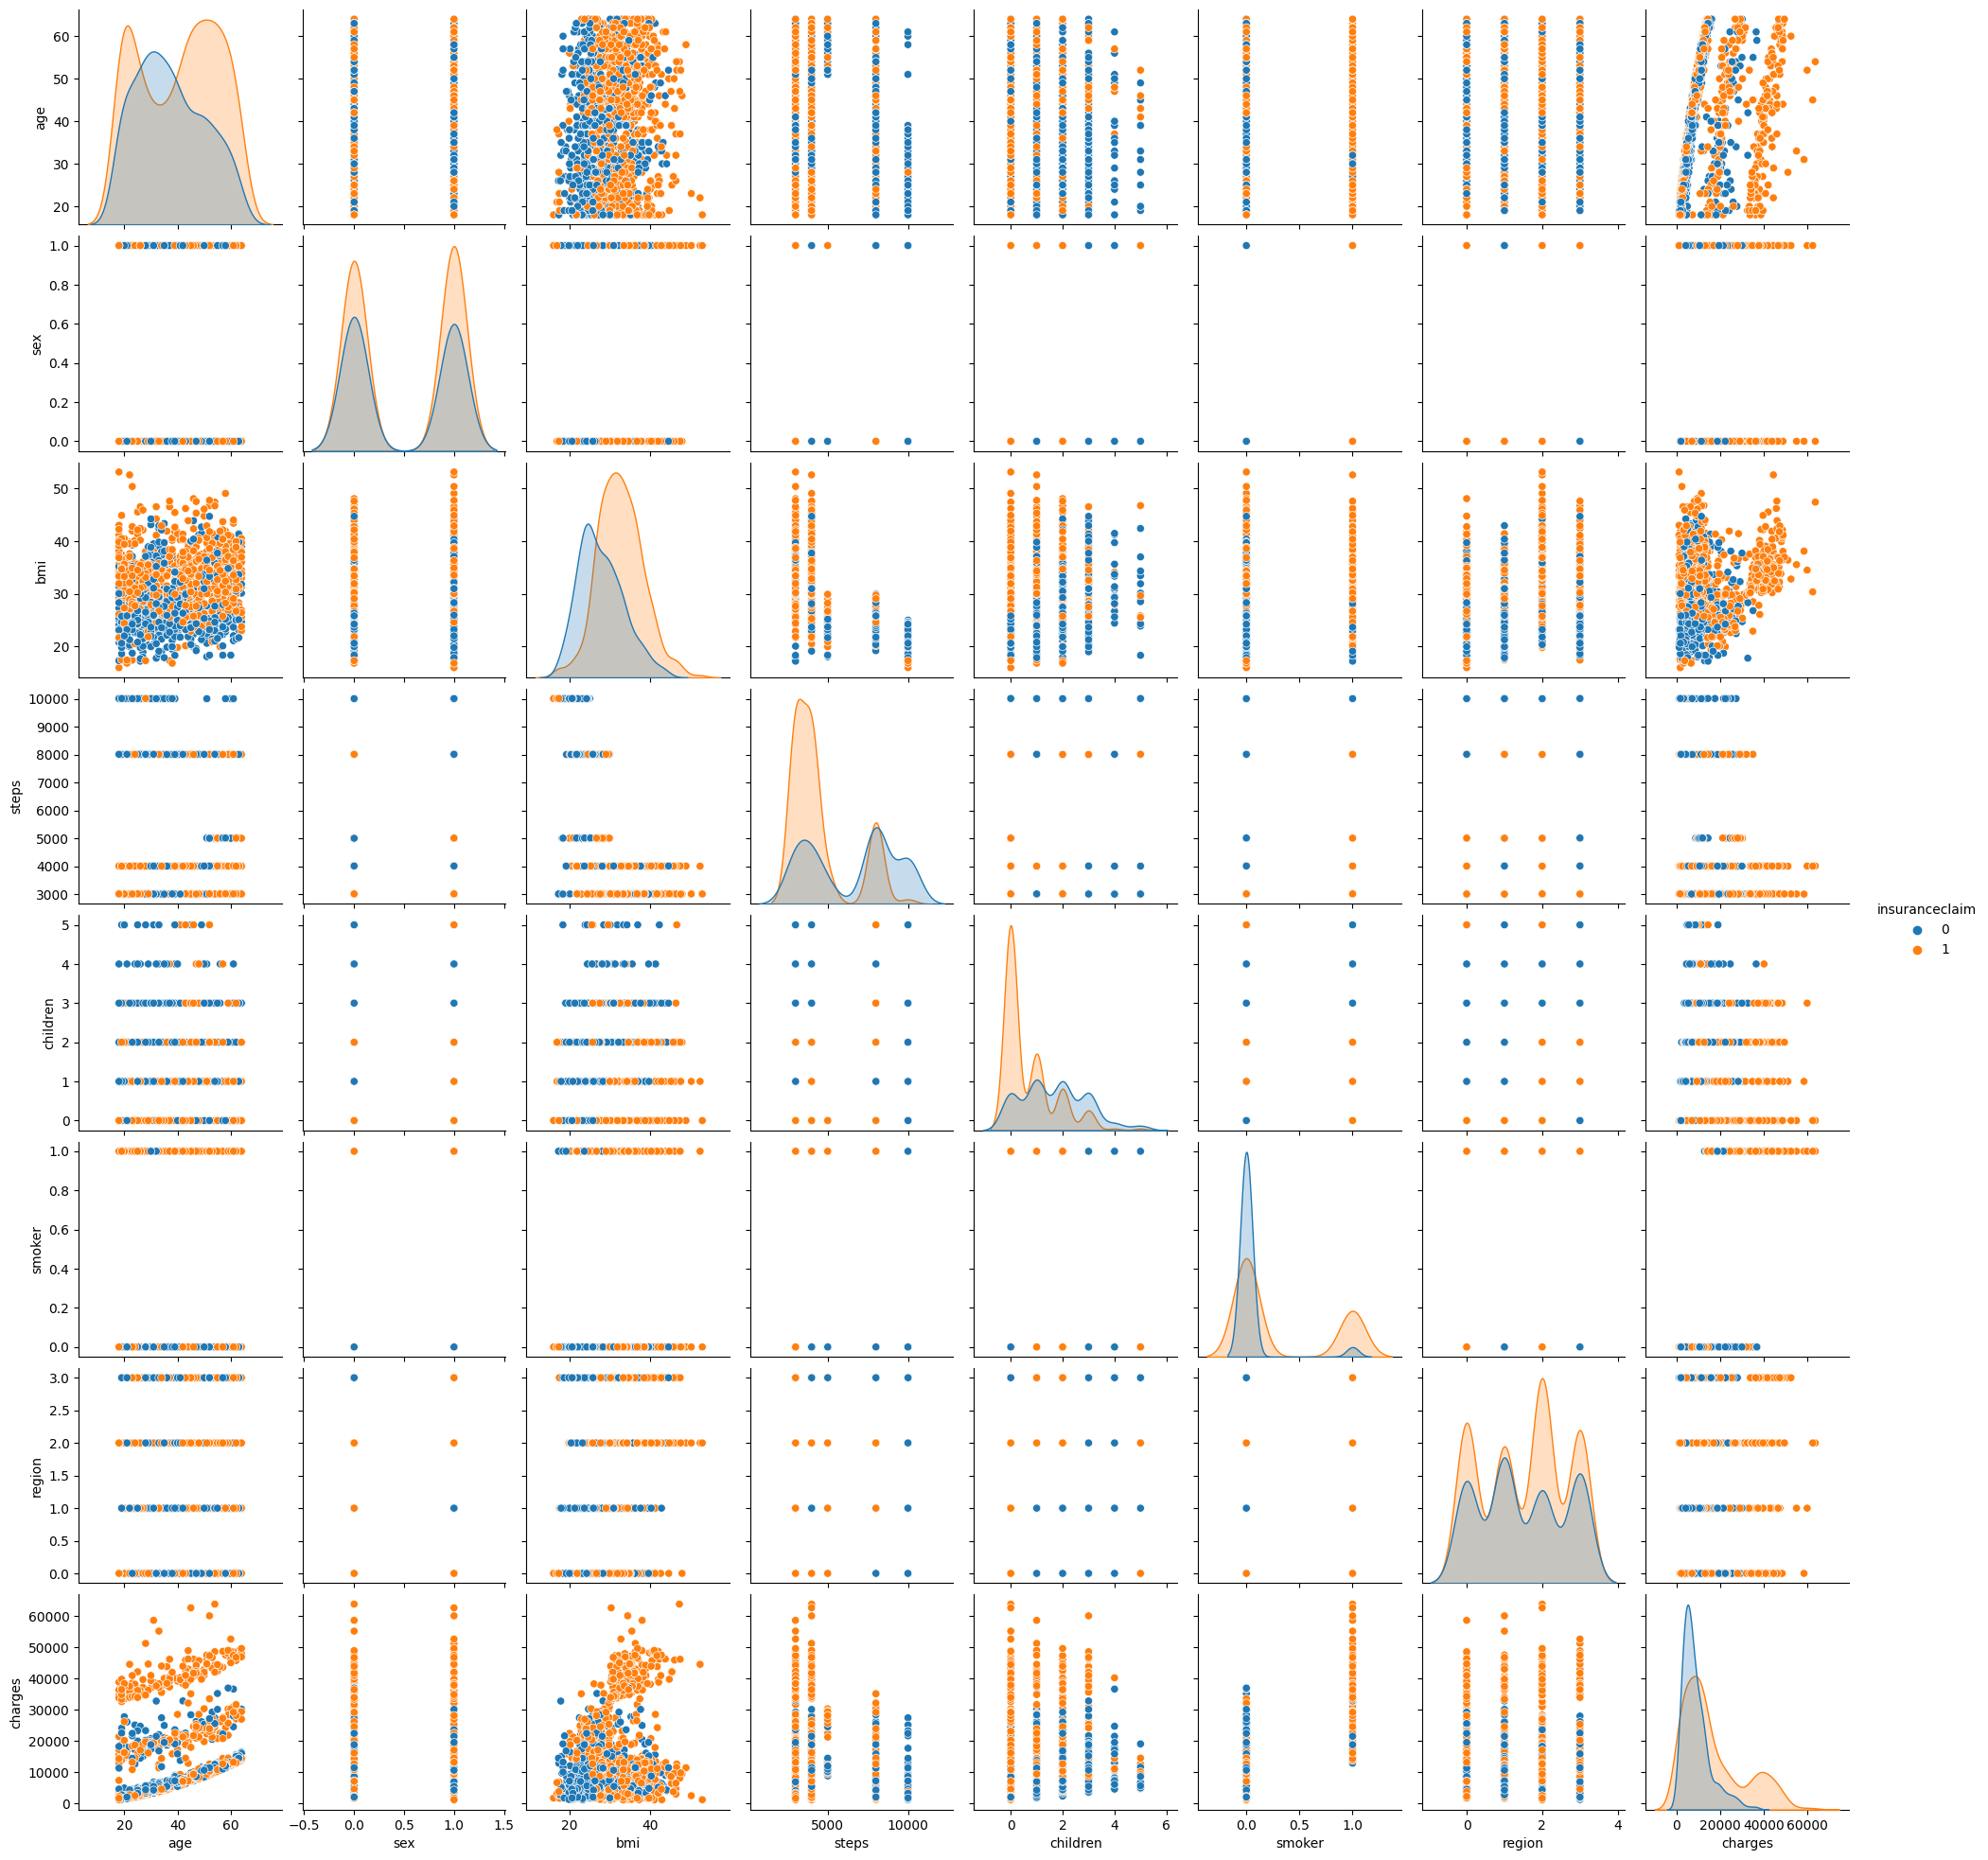

In [5]:
sns.pairplot(df, hue='insuranceclaim')
plt.show()

In [6]:
gender_mapping = {0:'female', 1:'male'}
smoker_mapping = {0:'non-smoker', 1:'smoker'}
region_mapping = {0:'northeast', 1:'northwest', 2:'southeast', 3:'southwest'}
insurance_mapping = {0:'no', 1:'yes'}
df['sex'] = df['sex'].replace(gender_mapping)
df['smoker'] = df['smoker'].replace(smoker_mapping)
df['region'] = df['region'].replace(region_mapping)
df['insuranceclaim'] = df['insuranceclaim'].replace(insurance_mapping)

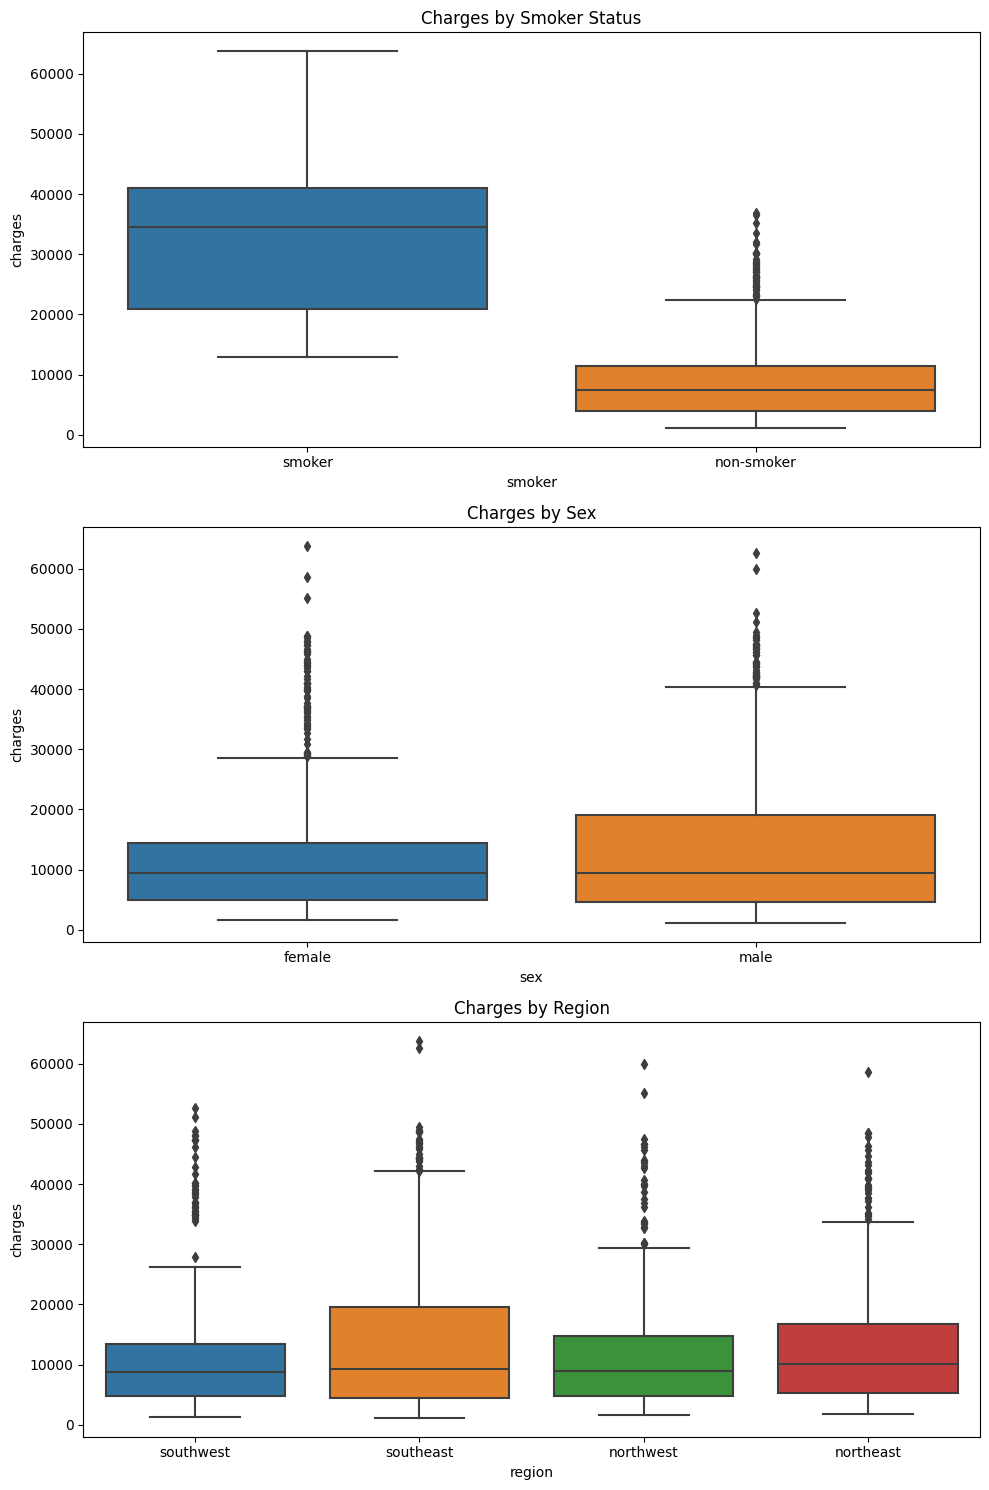

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.boxplot(x='smoker', y='charges', data=df, ax=axes[0])
axes[0].set_title('Charges by Smoker Status')

sns.boxplot(x='sex', y='charges', data=df, ax=axes[1])
axes[1].set_title('Charges by Sex')

sns.boxplot(x='region', y='charges', data=df, ax=axes[2])
axes[2].set_title('Charges by Region')

plt.tight_layout()
plt.show()

In [8]:
#Converting categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=['sex', 'smoker'], drop_first=True)
df = pd.get_dummies(df, columns=['region'], drop_first=False)


label_encoder = LabelEncoder()
df['insuranceclaim'] = label_encoder.fit_transform(df['insuranceclaim'])

# Splitting data into train and test sets
X = df.drop('insuranceclaim', axis=1)
y = df['insuranceclaim']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# training the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [10]:
y_pred = logreg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

Accuracy: 0.8656716417910447
Confusion Matrix:
[[ 91  16]
 [ 20 141]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       107
           1       0.90      0.88      0.89       161

    accuracy                           0.87       268
   macro avg       0.86      0.86      0.86       268
weighted avg       0.87      0.87      0.87       268



In [11]:
# 'age', 'bmi', 'steps', 'children', 'charges', 'sex_male', 'smoker_smoker', 'region_northeast', 'region_northwest',
# 'region_southeast', 'region_southwest'

new_data = pd.DataFrame({
    'age': [30],
    'bmi': [25],
    'steps': [5000],
    'children': [1],
    'charges': [5000],
    'sex_male': False,
    'smoker_smoker': False,
    'region_northeast': False,
    'region_northwest': False,
    'region_southeast': False,
    'region_southwest': True,
})
new_data = scaler.transform(new_data)
predicted_proba = logreg.predict_proba(new_data)
print(f"Probability of making a claim: {predicted_proba[0][1]}")

Probability of making a claim: 0.12196617953342548


In [12]:
data_scenario = pd.DataFrame({
    'age': [30, 30],
    'bmi': [25, 25],
    'steps': [5000, 5000],
    'children': [1, 1],
    'charges': [5000, 5000],
    'sex_male': [False, False],
    'smoker_smoker': [False, False],
    'region_northeast': [False, False],
    'region_northwest': [False, False],
    'region_southeast': [False, False],
    'region_southwest': [True, True],
})

data_scenario = scaler.transform(data_scenario)
probabilities_scenario = logreg.predict_proba(data_scenario)
print(f"Probability for 1: {probabilities_scenario[0][1]}")
print(f"Probability for 2: {probabilities_scenario[1][1]}")

Probability for 1: 0.12196617953342542
Probability for 2: 0.12196617953342542


In [13]:
coefficients = logreg.coef_


feature_names = X_train.columns
coeff_dict = dict(zip(feature_names, coefficients[0]))

for feature, coeff in coeff_dict.items():
    print(f"{feature}: {coeff}")

age: 0.4538607678884209
bmi: 1.728066626688035
steps: 0.16227785833674724
children: -1.741346875544393
charges: 0.02011695623389057
sex_male: 0.05064528016982399
smoker_smoker: 1.756128610374723
region_northeast: 0.13836494889546758
region_northwest: -0.08791322268068841
region_southeast: -0.03994022110144855
region_southwest: -0.011027977222859505


In [14]:
np.random.seed(42)
sample_size = 10

data = {
    'age': np.random.randint(20, 65, sample_size),
    'bmi': np.random.uniform(18.5, 35, sample_size),
    'steps': np.random.randint(2000, 15000, sample_size),
    'children': np.random.randint(0, 5, sample_size),
    'charges': np.random.uniform(1000, 40000, sample_size),
    'sex_male': np.random.choice([0, 1], sample_size),
    'smoker_smoker': np.random.choice([0, 1], sample_size)
}

# Generating region such that each instance belongs to only one region
regions = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
random_regions = np.random.choice(regions, sample_size)

for region in regions:
    data[region] = np.where(random_regions == region, 1, 0)

sample_df = pd.DataFrame(data)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sample_df)


predicted_probs = logreg.predict_proba(scaled_data)[:, 1]

# Add predicted probabilities to the original dataframe
sample_df['predicted_probs'] = predicted_probs

sample_df.head(10)

,age,bmi,steps,children,charges,sex_male,smoker_smoker,region_northeast,region_northwest,region_southeast,region_southwest,predicted_probs
0,58,26.077607,5385,2,38006.535953,1,1,0,1,0,0,0.877055
1,48,24.006192,14309,3,38659.649290,0,1,0,0,0,1,0.517351
2,34,20.857302,8396,3,32527.496577,1,1,0,1,0,0,0.149890
3,62,29.239660,13096,0,12879.936998,1,0,0,0,1,0,0.841128
4,27,19.430791,10666,2,4809.212446,1,0,0,0,0,1,0.004740
5,40,30.412980,11274,4,27685.088034,1,1,0,0,1,0,0.609461
6,58,33.986120,4558,2,18165.947256,1,1,0,0,0,1,0.989419
7,38,18.512850,9849,4,5759.491159,1,1,0,1,0,0,0.027773
8,42,34.871491,4047,0,20311.899494,1,1,0,0,1,0,0.998699
9,30,28.688445,4747,1,2341.152323,1,1,0,0,0,1,0.954691


In [15]:
label_encoder = LabelEncoder()
df['insuranceclaim'] = label_encoder.fit_transform(df['insuranceclaim'])

# Splitting data into train and test sets
X = df.drop('insuranceclaim', axis=1)
y = df['insuranceclaim']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scaling the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [16]:
logreg1 = LogisticRegression()
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [25]:
logreg1.feature_names_in_

array(['age', 'bmi', 'steps', 'children', 'charges', 'sex_male',
       'smoker_smoker', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'], dtype=object)

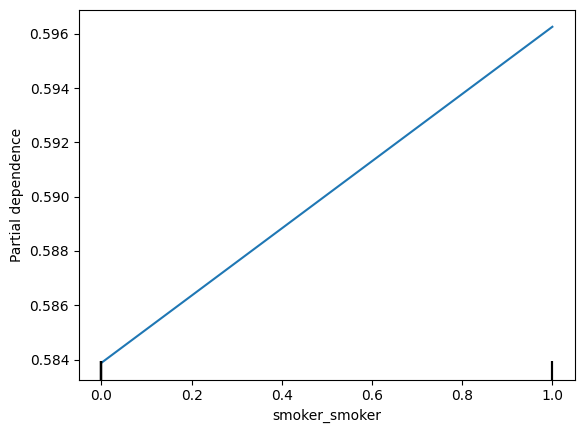

In [28]:
PartialDependenceDisplay.from_estimator(logreg1, X_train1, ['smoker_smoker'])